In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import warnings

from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm

from utils import display_metrics

## 1.Description de données 'energy_antananarivo'

- **date**: Date de dépôt de la demande
- **tot_nb_dmd**: Nombre total des demandes déposées
- **tot_energy**: Puissance total en KWh

Les données de la base 'energy_antananarivo' couvrent la période de janvier 2000 à décembre 2023. soit 288 données mensuelles.

In [4]:
df = pd.read_csv('energy_antananarivo_cleaned.csv', index_col='date', parse_dates=True)

### 1.1 Information supplémentaire sur le données

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 288 entries, 2000-01-01 to 2023-12-01
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   tot_nb_dmd  288 non-null    int64  
 1   tot_energy  288 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 6.8 KB


On voit que la variable 'date' est de type object(texte). Il faut la convertir en type Datetime pour pouvoir continuer à travailler 

Le modèle ARIMA est conçu pour les pour modéliser les séries temporelles univariées, ce qui signifie qu'il est utilisé pour analyser et prévoir des séries temporelles qui ne comportent qu'une seule variable à chaque instant de temps.  
Donc on doit supprimer une colonne de notre données et ne garder qu'une seule colonne. Etant données que nous voulions avoir une prédiction du nombre de demande à un mois de l'année, on va garder la colonne 'date' et supprimer 'tot_energy'.  
A part cela, Il est necessaire de définir la colonne 'date' en index de la table.

In [7]:
# Vérification des valeurs manquantes
df.isnull().sum()

tot_nb_dmd    0
dtype: int64

## 2. Identification du modèle

### 2.1 Traçage du graphique de données

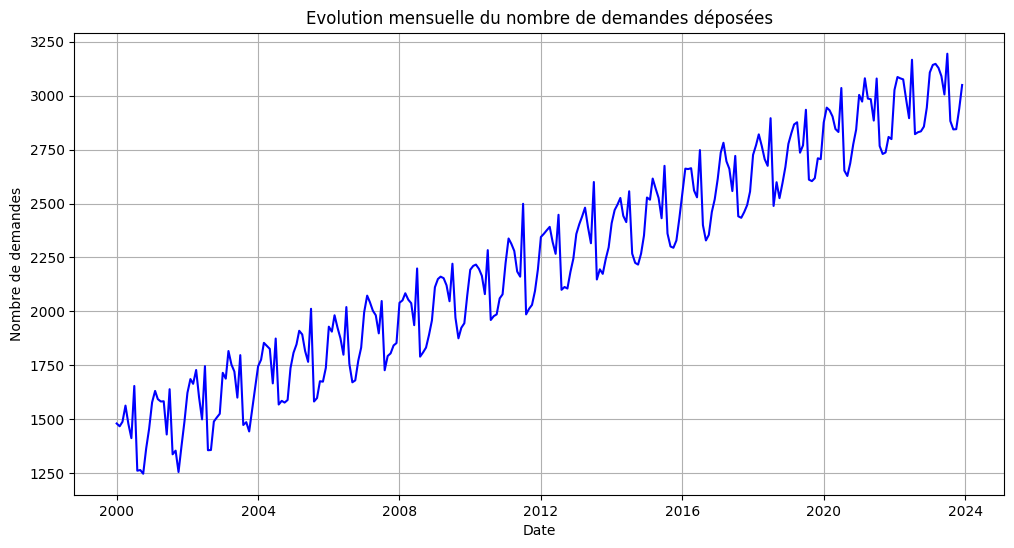

In [8]:
plt.figure(figsize=(12,6))
plt.plot(df.index, df.tot_nb_dmd, color='blue')
plt.title('Evolution mensuelle du nombre de demandes déposées')
plt.xlabel('Date')
plt.ylabel('Nombre de demandes')
plt.grid(True)
plt.show()

D'après le grapĥique, la série temporelle n'est pas stationnaire car:

- On constate une tendance qui augmente au fil du temps
- La moyenne n'est pas constante

Autres moyens de savoir si la série est stationnaire ou pas c'est d'utiliser les ACF et PACF.  
Les graphiques ACF et PACF sont couramment utilisés pour aider à choisir les paramètres d'un modèle ARIMA en analyse de series temporelles.

Par exemple: le graphique ACF est utilisé pour identifier le terme MA(moyenne mobile) du modèle. Tandisque le graphique de PACF peut être utilisé pour identifier le terme AR(auto-regressif).

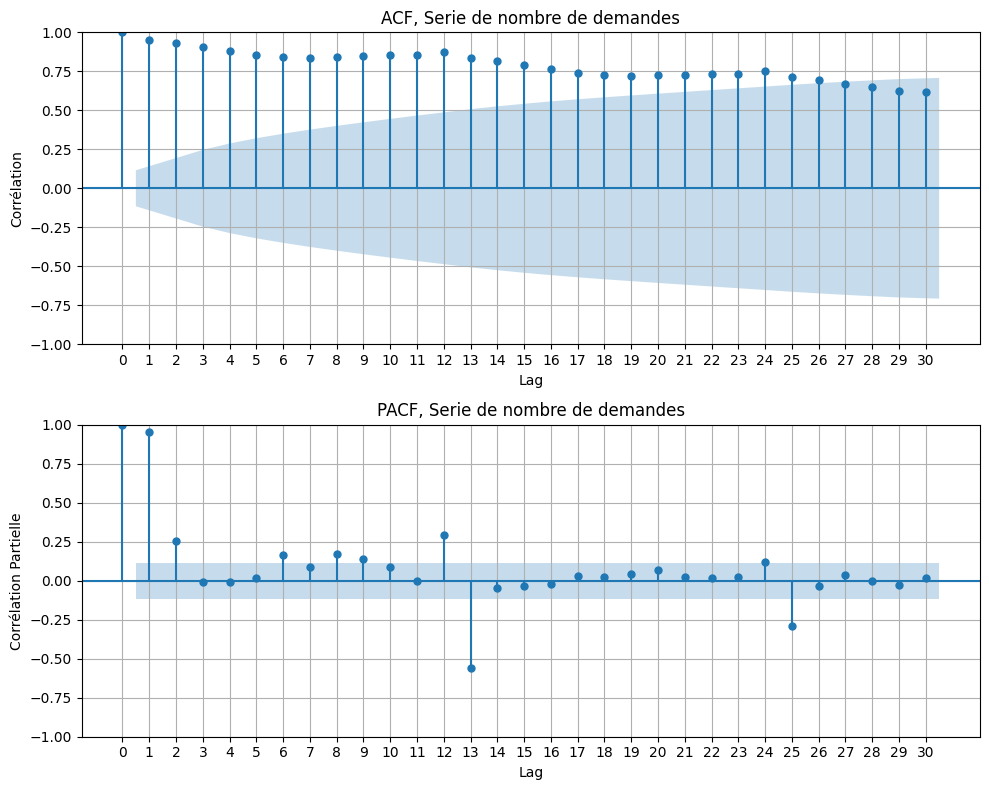

In [9]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Création des subplots 
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(10,8))

# Traçage l'ACF
plot_acf(df.tot_nb_dmd, lags=30, zero=True, ax=ax1)
ax1.set_title('ACF, Serie de nombre de demandes')
ax1.set_xlabel('Lag')
ax1.set_ylabel('Corrélation')
ax1.grid(True)

# Ajustement des graduations sur l'axe x pour l'ACF
ax1.set_xticks(np.arange(0,31,1))

# Traçage PACF
plot_pacf(df.tot_nb_dmd, lags=30, zero=True, ax=ax2)
ax2.set_title('PACF, Serie de nombre de demandes')
ax2.set_xlabel('Lag')
ax2.set_ylabel('Corrélation Partielle')
ax2.grid(True)

# Ajustement les graduations sur l'axe x pour le PACF
ax2.set_xticks(np.arange(0,31,1))

# Ajustement les subplots
plt.tight_layout()

plt.show()

**A propos de l'ACF**: le graphe montre qu'il y a une **decroissance regulière très lente pour la série**. Ce qui signifie déjà que la série est **non stationnaire**.

### 2.2 Analyse de la stationnarité de la variable

In [10]:

from statsmodels.tsa.stattools import adfuller
from tabulate import tabulate

# Test de Dickey-Fuller augmenté
result = adfuller(df)

# Formater les résultats dans un tableau
table = [
    ['Valeur de test', result[0]],
    ['P-valeur', result[1]],
    ['Conclusion', 'La série est stationnaire' if result[1] < 0.05 else 'La serie est non stationnaire']
]

print(tabulate(table, headers=['Metrique', 'Valeur'], tablefmt='github'))

| Metrique       | Valeur                        |
|----------------|-------------------------------|
| Valeur de test | 0.25857920216479957           |
| P-valeur       | 0.9753622446703388            |
| Conclusion     | La serie est non stationnaire |


**p-valeur(0.95) est supérieur à 0.05**, donc on rejette l'hypothèse nulle. Donc la série est **non stationnaire**.

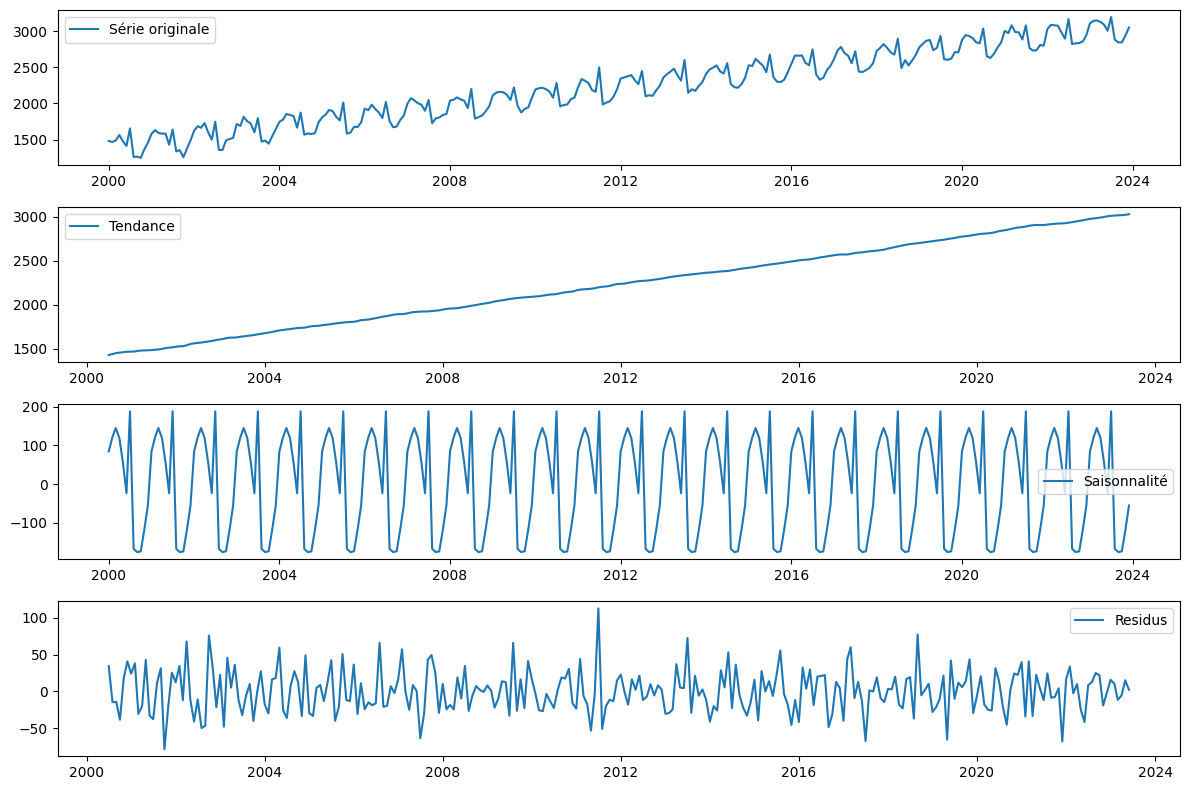

In [11]:
# Decompostion saisonnière
decomposition = seasonal_decompose(df.tot_nb_dmd, model='additive')

# Extraction des composantes de la decomposotion
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Affichage des composantes de la décomposition
plt.figure(figsize=(12,8))

plt.subplot(411)
plt.plot(df.tot_nb_dmd, label='Série originale')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Tendance')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal, label='Saisonnalité')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residual, label='Residus')
plt.legend(loc='best')

plt.tight_layout()
plt.show()

Etant donnée que la serie est non stationnaire, on doit faire la différenciation pour la rendre stationnaire.

### 2.3 Différenciation(Stationnarisation) de la série

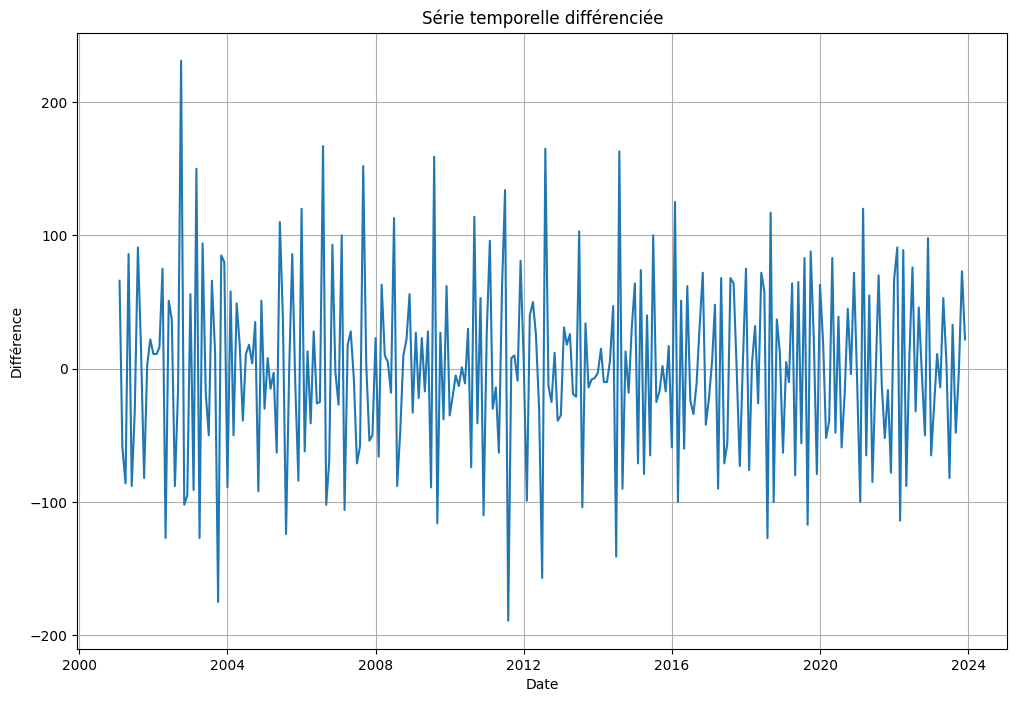

In [12]:
differenced = df.tot_nb_dmd.diff().dropna()

# Differenciation saisonnière 
differenced = differenced.diff(12).dropna()

# Afficher la série différenciée
plt.figure(figsize=(12,8))
plt.plot(differenced)
plt.title('Série temporelle différenciée')
plt.xlabel('Date')
plt.ylabel('Différence')
plt.grid(True)
plt.show()

Malgré l'existence des variances un peu élevées, c'est beaucoup plus stationnaire que la série original.

### Retraçage de l'ACF et PACF avec la serie différenciée

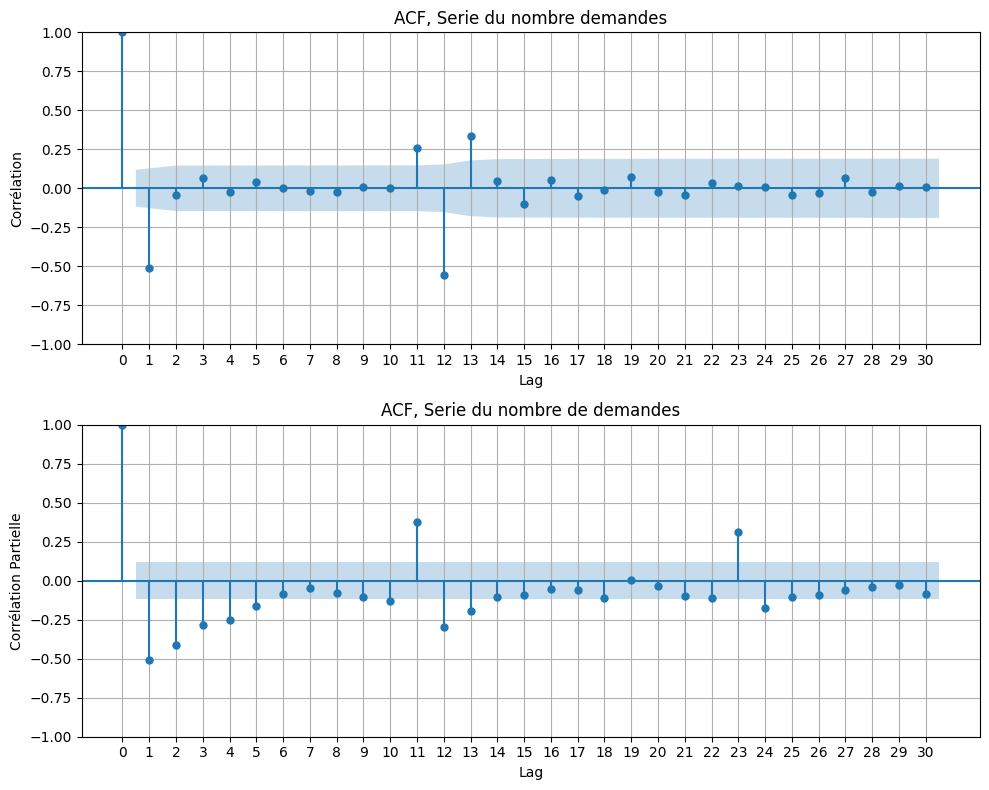

In [13]:
# Création des subplots 
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(10,8))

# Traçage de l'ACF
plot_acf(differenced, lags=30, zero=True, ax=ax1)
ax1.set_title('ACF, Serie du nombre demandes')
ax1.set_xlabel('Lag')
ax1.set_ylabel('Corrélation')
ax1.grid(True)

# Ajustement des graduations sur l'axe x pour l'ACF
ax1.set_xticks(np.arange(0,31,1))

# Traçage du PACF
plot_pacf(differenced, lags=30, zero=True, ax=ax2)
ax2.set_title('ACF, Serie du nombre de demandes')
ax2.set_xlabel('Lag')
ax2.set_ylabel('Corrélation Partielle')
ax2.grid(True)

# Ajustement des graduations sur l'axe x pour le PACF
ax2.set_xticks(np.arange(0,31,1))

# Ajustement des subplots
plt.tight_layout()

plt.show()

Concernant le graphe de l'ACF, le graphe montre l'absence de la décroissance lente. On peut dire que la série est maintenant stationnaire

In [14]:
import pmdarima as pm

train = df.tot_nb_dmd[:-15]
# Utilisation de l'auto_arima pour trouver le meilleur modèle ARIMA
model =  pm.auto_arima(train)

print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  273
Model:               SARIMAX(2, 1, 1)   Log Likelihood               -1703.222
Date:                Sun, 24 Mar 2024   AIC                           3414.444
Time:                        09:35:40   BIC                           3428.867
Sample:                    01-01-2000   HQIC                          3420.234
                         - 09-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4545      0.119      3.806      0.000       0.220       0.689
ar.L2          0.1310      0.102      1.290      0.197      -0.068       0.330
ma.L1         -0.9042      0.058    -15.565      0.0

### Analyse de la stationnarité de la variable avec la serie différenciée

In [15]:
# Test de Dickey-Fuller augmenté
result = adfuller(differenced)

# Formater les résultats dans un tableau
table = [
    ['Valeur de test', result[0]],
    ['P-valeur', result[1]],
    ['Conclusion', 'La série est stationnaire' if result[1] < 0.05 else 'La serie est non stationnaire']
]

print(tabulate(table, headers=['Metrique', 'Valeur'], tablefmt='github'))

| Metrique       | Valeur                    |
|----------------|---------------------------|
| Valeur de test | -7.440589773568235        |
| P-valeur       | 6.02048441821272e-11      |
| Conclusion     | La série est stationnaire |


### Identification de l'ordre de p,d,q
Pour identifier les p,q on revient dans les graphes:

- p est determiné à partir du graphe PACF:
- q est determiné à partir du graphe ACF:

In [16]:
p=2
d=1
q=1

## 3. Estimation du modèle

In [17]:
from statsmodels.tsa.arima.model import ARIMA

### 3.1 Création d'un modèle ARIMA

In [18]:
model = ARIMA(differenced, order=(2,1,1))

# Ajustement du modèle
model_fit = model.fit()

# Affichage du résumé du modèle
model_fit.summary()

/home/anthony/PycharmProjects/DL/Memoire INSI/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/anthony/PycharmProjects/DL/Memoire INSI/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/anthony/PycharmProjects/DL/Memoire INSI/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             tot_nb_dmd   No. Observations:                  275
Model:                 ARIMA(2, 1, 1)   Log Likelihood               -1480.565
Date:                Sun, 24 Mar 2024   AIC                           2969.131
Time:                        09:36:27   BIC                           2983.583
Sample:                    02-01-2001   HQIC                          2974.932
                         - 12-01-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7199      0.057    -12.622      0.000      -0.832      -0.608
ar.L2         -0.4115      0.059     -7.005      0.000      -0.527      -0.296
ma.L1         -0.9995      0.806     -1.241      0.215      -2.578       0.579
sigma2      2810.8530   2244.879      1.252      0.211   -1589.028    7210.734
===================================================================================
Ljung-Box (L1) (Q):                   3.84   Jarque-Bera (JB):                 1.71
Prob(Q):                              0.05   Prob(JB):                         0.43
Heteroskedasticity (H):               0.71   Skew:                             0.18
Prob(H) (two-sided):                  0.10   Kurtosis:                         3.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## 7. Vérification du modèle

<Figure size 1200x800 with 0 Axes>

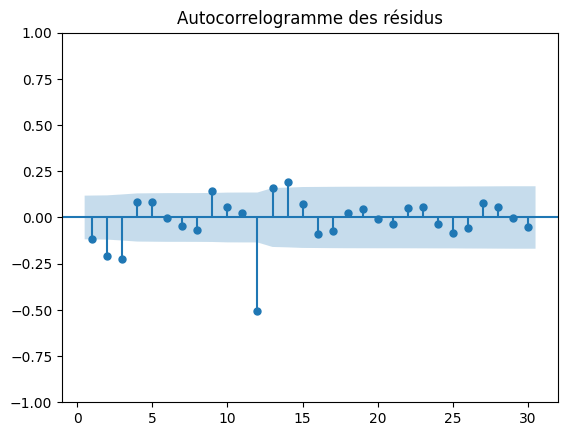

<Figure size 1200x800 with 0 Axes>

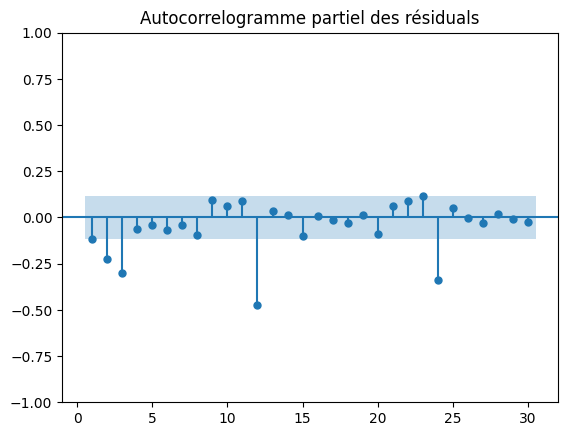

In [19]:
# calculer les résidus
residuals = model_fit.resid

# Tracer l'ACF des résidus
plt.figure(figsize=(12,8))
plot_acf(residuals, lags=30, zero=False)
plt.title('Autocorrelogramme des résidus')
plt.show()

# Tracer la PACF des résidus
plt.figure(figsize=(12,8))
plot_pacf(residuals, lags=30, zero=False)
plt.title('Autocorrelogramme partiel des résiduals')
plt.show()

Il y a quelques pics significatives dans PACF et ACF, mais globalement, on peut dire que les résidus sont des bruits blanc parceque on est, plus ou moins dans les bons résidus. Il faut se rappeler que les bruits sont des bruits blanc s'ils se trouvent à l'intérieur des zone bleues du graphique.

## 8. Prédiction

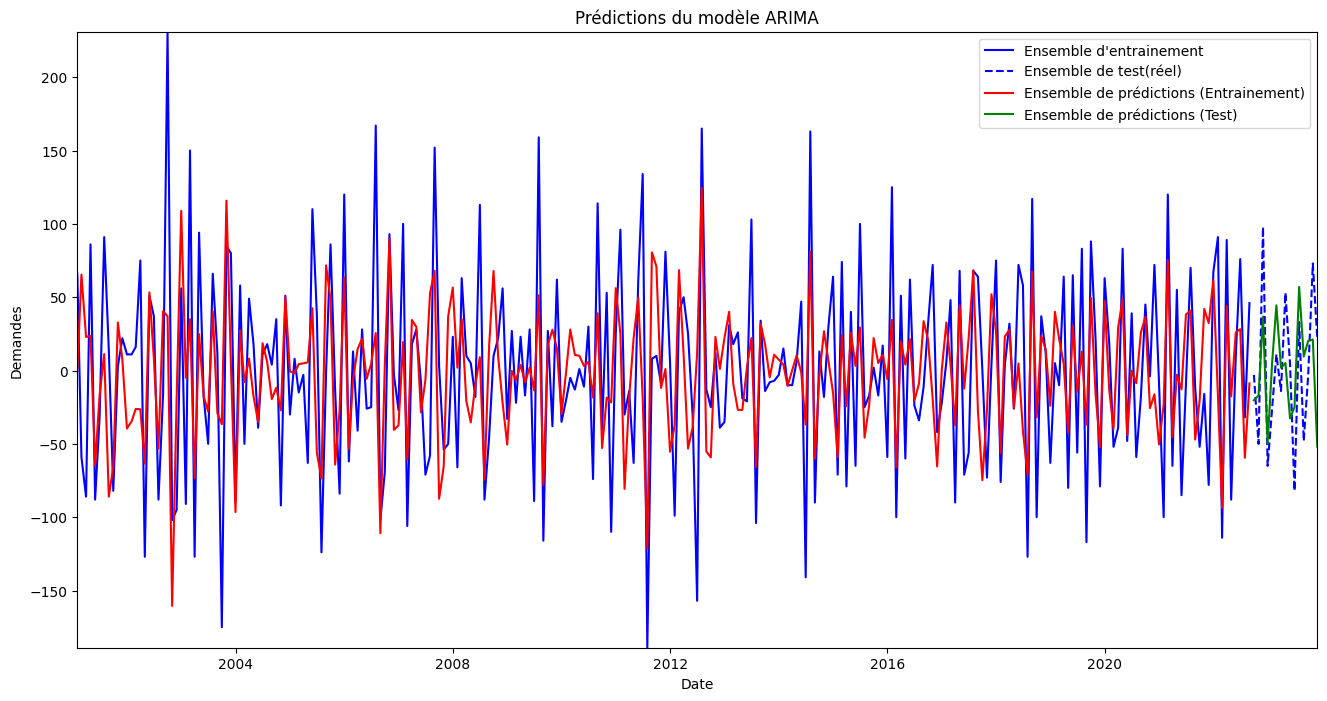

In [20]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Repartition des sets
train = differenced[:-15]
test = differenced[-15:]

# Prédiction sur l'ensemble d'entrainement
train_prediction = model_fit.predict(start=train.index[0], end=train.index[-1])

# Prédiction sur l'ensemble de test
test_prediction = model_fit.predict(start=test.index[0], end=test.index[-1])

# Traçage des predictions et les données réels avec les courbes collées.
plt.figure(figsize=(16,8))
plt.plot(train.index, train.values, label='Ensemble d\'entrainement', color='blue')
plt.plot(test.index, test.values, label='Ensemble de test(réel)', linestyle='--', color='blue')
plt.plot(train_prediction.index, train_prediction.values, label='Ensemble de prédictions (Entrainement)', color='red')
plt.plot(test_prediction.index, test_prediction.values, label='Ensemble de prédictions (Test)', color='green')

# Définition des limites des axes x et y pour une continuté visuelle.
plt.xlim(train.index[0], test.index[-1])
plt.ylim(min(train.min(), test.min()), max(train.max(), test.max()))

plt.xlabel('Date')
plt.ylabel('Demandes')
plt.title('Prédictions du modèle ARIMA')
plt.legend()
plt.show()

D'après le graphe:

- La prédiction de l'ensemble d'entrainement est bonne; elle(rouge) suit la courbe bleu
- Mais la prédiction de l'ensemble de test(vert) n'est pas bonne

In [21]:
perf = display_metrics(train, train_prediction, test, test_prediction)
perf

/home/anthony/PycharmProjects/DL/Memoire INSI/venv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/anthony/PycharmProjects/DL/Memoire INSI/venv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


,Métriques:,Ensemble d'entrainenemt:,Ensemble de test:
0,MAE,44.043667,38.615328
1,MSE,3012.170934,1812.227252
2,RMSE,54.883248,42.570263
3,R²,0.358842,0.245805


On constate, d'après les mesures de métriques, que le modèle n'est pas bon

## 9. Processus de selection de modèle automatique

In [22]:
import pmdarima as pm

# Utilisation de l'auto_arima pour trouver le meilleur modèle ARIMA
model =  pm.auto_arima(train, seasonal=True, m=12)

print(model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  260
Model:             SARIMAX(5, 0, 0)x(2, 0, 0, 12)   Log Likelihood               -1320.740
Date:                            Sun, 24 Mar 2024   AIC                           2657.480
Time:                                    09:38:53   BIC                           2685.966
Sample:                                02-01-2001   HQIC                          2668.932
                                     - 09-01-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8335      0.061    -13.603      0.000      -0.954      -0.713
ar.L2         -0.6741      0.084   

Le resultat nous indique que la meilleur modèle est: 
- SARIMAX(5, 0, 0)x(2, 0, 0, 12)

 ### 9.1 Ajustement du modèle aux données

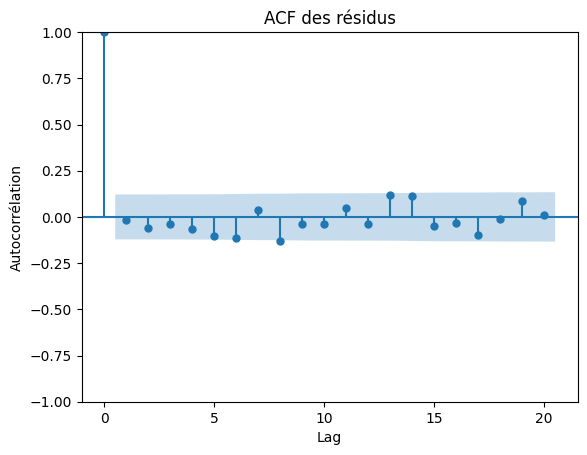

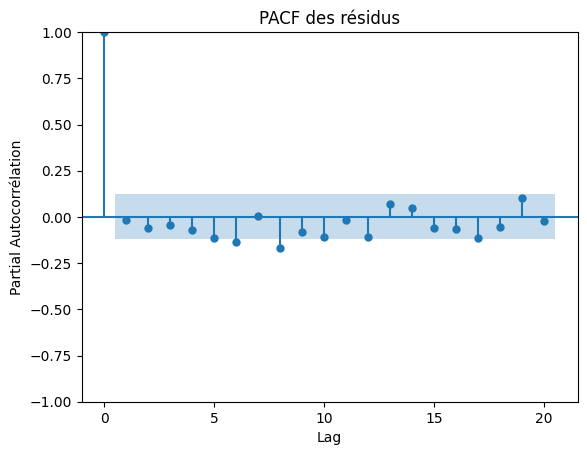

In [23]:
# Obtention des résidus du modèle
residuals = model.resid()

# Traçage de la fonction d'autocorrélation ACF des résidus
plot_acf(residuals, lags=20)
plt.xlabel('Lag')
plt.ylabel('Autocorrélation')
plt.title('ACF des résidus')
plt.show()

# Traçage de la fonction d'autocorrélation partielle PACF des résidus
plot_pacf(residuals, lags=20)
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrélation')
plt.title('PACF des résidus')
plt.show()

On voit moins de pics significatifs que dans l'autre graphe. La plupart des bruits sont à l'intérieur de la zone bleue.

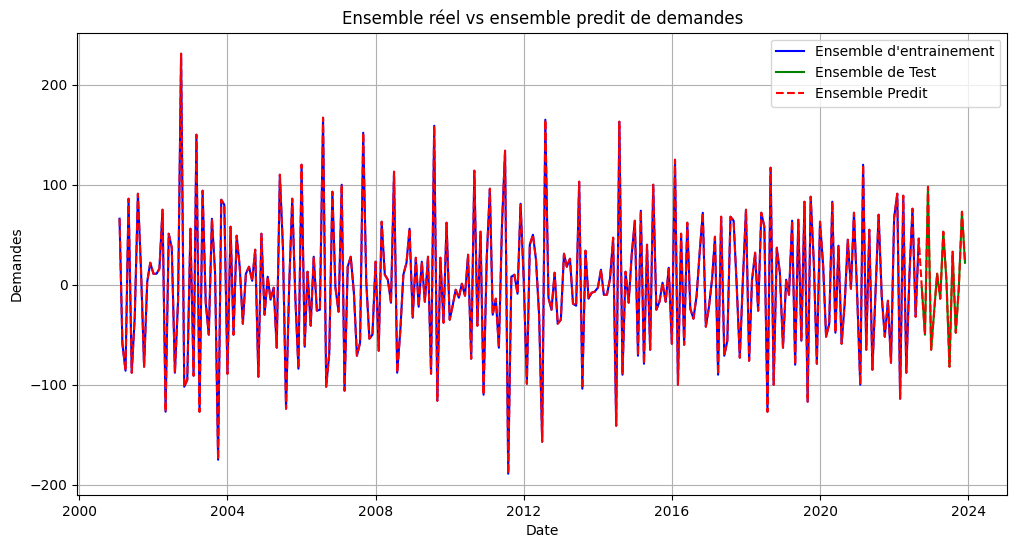

In [24]:
# Prédictions sur l'ensemble des données d'entrainement
train_pred, train_confint = model.predict_in_sample(return_conf_int=True)

# Prédictions sur l'ensemble des données de test
n_periods = len(test)
predictions ,confint = model.predict(n_periods=n_periods, return_conf_int=True)

# Concatenation des prédictions sur l'ensemble de test
all_predictions = pd.concat([pd.Series(data=train_pred, index=train.index), 
                            pd.Series(data=predictions, index=test.index)],
                           axis=0)

# Traçage des valeurs réelles et les prédictions pour l'ensemble d'entrainement et de test
plt.figure(figsize=(12,6))
plt.plot(train, label="Ensemble d'entrainement", color='blue')
plt.plot(test, label='Ensemble de Test', color='green')
plt.plot(differenced, label='Ensemble Predit', color='red', linestyle='--')

plt.xlabel('Date')
plt.ylabel('Demandes')
plt.title('Ensemble réel vs ensemble predit de demandes')
plt.legend()
plt.grid(True)
plt.show()

In [25]:
# Mesures de performances sur l'ensemble de test
test_mae = mean_absolute_error(test, predictions)
test_mse = mean_squared_error(test, predictions)
test_rmse = mean_squared_error(test, predictions, squared=False)
test_r2 = r2_score(test, predictions)

# Création d'un Dataframe pour afficher les mesures de performance
perf_df = pd.DataFrame({
    'Métriques:': ['MAE', 'MSE', 'RMSE', 'R²'],
    'Ensemble de test:': [test_mae, test_mse, test_rmse, test_r2]
})

perf_df

/home/anthony/PycharmProjects/DL/Memoire INSI/venv/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


,Métriques:,Ensemble de test:
0,MAE,30.754324
1,MSE,1340.590736
2,RMSE,36.614078
3,R²,0.442086


## Ré-entrainement avec l'ensemble de toutes les données

In [26]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model_sarima = SARIMAX(df, order=(5, 0, 0), seasonal_order=(2, 0, 0, 12))
model_sarima_fit = model_sarima.fit()

/home/anthony/PycharmProjects/DL/Memoire INSI/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/anthony/PycharmProjects/DL/Memoire INSI/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/anthony/PycharmProjects/DL/Memoire INSI/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/anthony/PycharmProjects/DL/Memoire INSI/venv/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.55458D+02    |proj g|=  2.97617D+02

At iterate    5    f=  5.99515D+00    |proj g|=  1.93783D-01

At iterate   10    f=  5.90709D+00    |proj g|=  6.62158D-03

At iterate   15    f=  5.84208D+00    |proj g|=  4.29067D-02

At iterate   20    f=  5.51254D+00    |proj g|=  2.00251D-01

At iterate   25    f=  5.28301D+00    |proj g|=  9.39233D-02

At iterate   30    f=  5.24974D+00    |proj g|=  1.81087D-02

At iterate   35    f=  5.24917D+00    |proj g|=  1.73599D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

In [27]:
# Utiliser les paramètres internes du modèle pour faire des prédictions
predictions = model_sarima_fit.predict(start=len(df))


In [28]:
model_sarima_fit.forecast(12)

2024-01-01    3157.813295
2024-02-01    3207.012614
2024-03-01    3218.601662
2024-04-01    3214.398360
2024-05-01    3153.094330
2024-06-01    3056.028618
2024-07-01    3284.512648
2024-08-01    2966.476994
2024-09-01    2952.707750
2024-10-01    2954.493748
2024-11-01    3009.157051
2024-12-01    3106.267900
Freq: MS, Name: predicted_mean, dtype: float64

In [71]:
import pickle

# Enregistrement de la fonction dans un fichier pickle
# with open('model_arima_fit.pkl', 'wb') as pkl_file:
#     pickle.dump(model_sarima_fit, pkl_file)